Labeling of all articles on trading day "d" based on whether the USD/BRL exchange rate increased/decreased or hovered around a .2% increase/decrease on trading day "d"
- Increase: +1
- Decrease: -1
- Neutral: 0

Approach failed

In [ ]:
'''
# Word2Vec approach by applying +1, -1, 0 labels to ALL articles per trading day whether the BRL went up down or stayed around the same based on a .2% threshold.
# 0 for neutral
# +1 for up
# -1 for down

labels = {
    '09/01/24': 1,
    '10/01/24': 0,
    '11/01/24': -1,
    '12/01/24': -1, 
    '15/01/24': 1,
    '16/01/24': 1,
    '19/01/24': 0,
    '22/01/24': 1,
    '23/01/24': -1,
    '24/01/24': -1,
    '25/01/24': -1,
    '26/01/24': -1,
    '29/01/24': 1,
    '30/01/24': 1,
    '31/01/24': 1
}

# add lablels to df
df_template['label'] = df_template['date'].map(labels) # called df_template because I might use this in the future for any month

'''


## FIRST RUN

Multinomial Logistic Regression Model with Custom Word2Vec Model

Task: 
- Train on January, test on first 2 weeks of February respectively
    - Train / test with 3 classes (+1, 0, -1), yielding a 3 x 3 confusion matrix
    - Train / test with 2 classes (+1, -1), yielding a 2 x 2 confusion matrix

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder

# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# 1. combine january and february for word2vec training
print("training word2vec...")
combined_sentences = df_jan['preprocessed_article'].tolist() + df_feb['preprocessed_article'].tolist()
combined_sentences = [sentence.split() for sentence in combined_sentences]  # tokenize

# train word2vec
word2vec_model = Word2Vec(sentences=combined_sentences, vector_size=100, window=5, min_count=2, workers=4, epochs=10)
print("word2vec training complete.\n")

# function to convert articles to average word2vec vectors
def vectorize_articles(df, model):
    vectors = []
    for article in df['preprocessed_article']:
        words = article.split()
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if word_vectors:
            vectors.append(np.mean(word_vectors, axis=0))
        else:
            vectors.append(np.zeros(model.vector_size))  # handle empty articles
    return np.array(vectors)

# 2. prepare training and testing data
print("vectorizing articles...")
X_train = vectorize_articles(df_jan, word2vec_model)  # train on january
y_train = df_jan['label'].values

# Test on the first quarter of february dataframe (first 25% of df_feb)
quarter_feb_len = len(df_feb) // 4  # first quarter of february dataframe (25% of the rows)
df_feb_test = df_feb.iloc[:quarter_feb_len]  # first quarter of the dataframe
X_test = vectorize_articles(df_feb_test, word2vec_model)
y_test = df_feb_test['label'].values

# 3. apply smote to balance training data
print("applying smote to balance classes...")
smote = SMOTE(sampling_strategy='auto', random_state=random_seed)  # targeting only minority classes
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# check new label distribution
print("resampled label distribution:")
print(pd.Series(y_train_resampled).value_counts())

# 4. train random forest classifier with class weights
print("training random forest classifier with class weights...")
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=random_seed, n_estimators=100)
rf_clf.fit(X_train_resampled, y_train_resampled)

# 5. evaluate the model on the first quarter of february dataframe
print("evaluating model on first quarter of february test data...")
y_pred = rf_clf.predict(X_test)

# classification report
report = classification_report(y_test, y_pred)
print(report)

training word2vec...
word2vec training complete.

vectorizing articles...
applying smote to balance classes...
resampled label distribution:
 0    556
-1    556
 1    556
Name: count, dtype: int64
training random forest classifier with class weights...
evaluating model on first quarter of february test data...
              precision    recall  f1-score   support

          -1       0.26      0.51      0.35        41
           0       0.80      0.64      0.71       151
           1       0.31      0.24      0.27        37

    accuracy                           0.55       229
   macro avg       0.46      0.46      0.44       229
weighted avg       0.62      0.55      0.57       229



In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder

# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# 1. combine january and february for word2vec training
print("training word2vec...")
combined_sentences = df_jan['preprocessed_article'].tolist() + df_feb['preprocessed_article'].tolist()
combined_sentences = [sentence.split() for sentence in combined_sentences]  # tokenize

# train word2vec
word2vec_model = Word2Vec(sentences=combined_sentences, vector_size=100, window=5, min_count=2, workers=4, epochs=10)
print("word2vec training complete.\n")

# function to convert articles to average word2vec vectors
def vectorize_articles(df, model):
    vectors = []
    for article in df['preprocessed_article']:
        words = article.split()
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if word_vectors:
            vectors.append(np.mean(word_vectors, axis=0))
        else:
            vectors.append(np.zeros(model.vector_size))  # handle empty articles
    return np.array(vectors)

# 2. prepare training and testing data, excluding class 0
print("vectorizing articles...")

# Filter out class 0 for both training and testing data
df_jan_filtered = df_jan[df_jan['label'] != 0]
df_feb_filtered = df_feb[df_feb['label'] != 0]

X_train = vectorize_articles(df_jan_filtered, word2vec_model)  # train on january (without class 0)
y_train = df_jan_filtered['label'].values

# Test on the first quarter of February dataframe (25% of rows, excluding class 0)
quarter_feb_len = len(df_feb_filtered) // 4  # first quarter of february dataframe (25% of the rows)
df_feb_test = df_feb_filtered.iloc[:quarter_feb_len]  # first quarter of the dataframe
X_test = vectorize_articles(df_feb_test, word2vec_model)
y_test = df_feb_test['label'].values

# 3. apply smote to balance training data
print("applying smote to balance classes...")
smote = SMOTE(sampling_strategy='auto', random_state=random_seed)  # targeting only minority classes
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# check new label distribution
print("resampled label distribution:")
print(pd.Series(y_train_resampled).value_counts())

# 4. train binomial logistic regression
print("training binomial logistic regression...")
clf = LogisticRegression(solver='lbfgs', max_iter=1000)
clf.fit(X_train_resampled, y_train_resampled)

# 5. evaluate the model on the first quarter of february dataframe
print("evaluating model on first quarter of february test data...")
y_pred = clf.predict(X_test)

# classification report
report = classification_report(y_test, y_pred)
print(report)

training word2vec...
word2vec training complete.

vectorizing articles...
applying smote to balance classes...
resampled label distribution:
-1    363
 1    363
Name: count, dtype: int64
training binomial logistic regression...
evaluating model on first quarter of february test data...
              precision    recall  f1-score   support

          -1       0.41      0.47      0.44        30
           1       0.52      0.46      0.49        37

    accuracy                           0.46        67
   macro avg       0.46      0.46      0.46        67
weighted avg       0.47      0.46      0.46        67



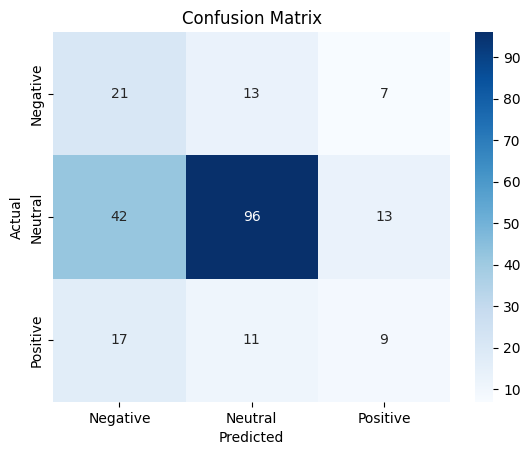

In [ ]:
# Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# y_test is actual labels and y_pred is predicted labels
cm = confusion_matrix(y_test, y_pred)

# heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# display plot
plt.show()

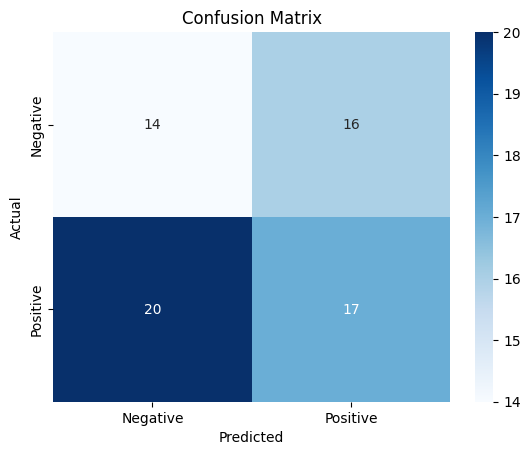

In [ ]:
# Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# y_test is actual labels and y_pred is predicted labels
cm = confusion_matrix(y_test, y_pred)

# heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# display plot
plt.show()